# Set up Python and R environments

In [ ]:
!pip install anndata2ri
!pip install sc_toolbox

In [3]:
import anndata2ri
anndata2ri.activate() # Activate the conversion of AnnData objects to R data type
%load_ext rpy2.ipython

/var/folders/8p/9jl2wyz136b60m4bwf608msr0000gn/T/ipykernel_2636/538058082.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate() # Activate the conversion of AnnData objects to R data type


In [4]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import random
import sc_toolbox
import rpy2.rinterface_lib.callbacks
import rpy2
print(rpy2.__version__)
import anndata2ri
import logging
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0 # Configure scanpy to not print any output messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Reduce logging messages from the R interface
pandas2ri.activate() # Activate the conversion of pandas DataFrames to R data type

3.5.14


In [ ]:
# %%R
# if (!require('BiocManager', quietly = TRUE))
#     install.packages('BiocManager')

# BiocManager::install(c('edgeR', 'MAST'))

In [5]:
%%R
library(edgeR)

Loading required package: limma


In [6]:
def count_entries(df, *args):
    """Return a dictionary with counts of occurrences as value for each key."""
    cols_count = {}
    for col_name in args:
        col = df[col_name]
        for entry in col:
            if entry in cols_count.keys():
                cols_count[entry] += 1
            else:
                cols_count[entry] = 1
    return cols_count

# Prepare the dataset

In [ ]:
!pwd

In [7]:
# This is a preprocessed data that filter cells with less than 200 genes and genes found in less than 3 cells
adata = ad.read_h5ad('adata_v2.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 62186 × 21231
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'sm_cluster_3', 'sm_cluster_5', 'sm_cluster_7', 'sm_cluster_9', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
adata[0:100,0:100].to_df()

gene,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ABLIM2,ABO,ABR,ABRA,ABRACL,ABRAXAS1,ABRAXAS2,ABT1,ABTB1,ABTB2
obs_id,,,,,,,,,,,,,,,,,,,,,
0000233976e3cd37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
0001533c5e876362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00022f989630d14b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
0002560bd38ce03e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002771c64e94903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0053c28a68667d33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
005439062a521170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0056d9b9e10266a6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [10]:
np.max(adata.X)

2008.0

In [11]:
np.min(adata.X)

0.0

In [12]:
adata.obs

,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,...,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier
obs_id,,,,,,,,,,,,,,,,,,,,,
0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,...,1602,7.379632,5553.0,8.622274,27.174500,341.0,5.834811,6.140825,False,False
0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,...,1431,7.266827,4051.0,8.306966,24.487781,281.0,5.641907,6.936559,False,False
00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,...,1430,7.266129,4510.0,8.414274,26.629712,343.0,5.840642,7.605322,False,False
0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,...,1331,7.194437,4004.0,8.295299,28.796204,312.0,5.746203,7.792208,False,False
0002771c64e94903,library_0,plate_3,D1,D,1,PBMC,donor_1,T cells CD8+,LSM-43181,Belinostat,...,1860,7.528869,6833.0,8.829665,26.240304,453.0,6.118097,6.629592,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff9ef161a5bfa33,library_14,plate_5,C4,C,4,PBMC,donor_1,T cells CD4+,LSM-1172,TGX 221,...,2046,7.624131,8830.0,9.086024,24.824462,650.0,6.478510,7.361268,False,False
fffab23ff3de1e9a,library_26,plate_5,F7,F,7,PBMC,donor_1,T cells CD8+,LSM-4944,MLN 2238,...,1480,7.300473,4648.0,8.444407,30.873494,265.0,5.583496,5.701377,False,False
fffb7ee424643703,library_0,plate_3,D12,D,12,PBMC,donor_1,T cells CD4+,LSM-3828,Vorinostat,...,1569,7.358831,6408.0,8.765459,29.822097,380.0,5.942799,5.930087,False,False


In [13]:
adata.layers['counts'] = adata.X.copy()

In [14]:
adata

AnnData object with n_obs × n_vars = 62186 × 21231
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'sm_cluster_3', 'sm_cluster_5', 'sm_cluster_7', 'sm_cluster_9', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [15]:
# Treat sm_name as a categorical variable - cat, 
# get the distinct categories - categories, 
# and calculate the number of categories - len
len(adata.obs.sm_name.cat.categories)

146

In [16]:
adata.obs['condition'] = ['perturbated' if sm_i == 'Belinostat' else 'control' for sm_i in adata.obs['sm_name']]

In [17]:
# Convert the condition into categories
adata.obs.condition = adata.obs.condition.astype('category')

In [18]:
adata.obs.condition

obs_id
0000233976e3cd37        control
0001533c5e876362        control
00022f989630d14b        control
0002560bd38ce03e        control
0002771c64e94903    perturbated
                       ...     
fff9ef161a5bfa33        control
fffab23ff3de1e9a        control
fffb7ee424643703        control
fffc0f266011f710        control
fffdafaabb2b2c4d        control
Name: condition, Length: 62186, dtype: category
Categories (2, object): ['control', 'perturbated']

In [19]:
adata.obs.condition.cat.categories

Index(['control', 'perturbated'], dtype='object')

In [20]:
count_entries(adata.obs, 'condition')

{'control': 56328, 'perturbated': 5858}

In [21]:
count_entries(adata.obs, 'plate_name')

{'plate_3': 16518,
 'plate_0': 10291,
 'plate_2': 10722,
 'plate_4': 6099,
 'plate_5': 15719,
 'plate_1': 2837}

In [22]:
df = adata.obs
crosstab = pd.crosstab(df['condition'], df['plate_name'], margins=False)
print(crosstab)

plate_name   plate_0  plate_1  plate_2  plate_3  plate_4  plate_5
condition                                                        
control         9407     2617     9712    14786     5551    14255
perturbated      884      220     1010     1732      548     1464


In [23]:
con_1 = (df['condition'] == 'perturbated') & (df['plate_name'].isin(['plate_2', 'plate_3', 'plate_5']))
con_2 = (df['condition'] == 'control') & (df['plate_name'].isin(['plate_0', 'plate_1', 'plate_4']))

In [24]:
bdata = adata[con_1 | con_2]

In [25]:
df_2 = bdata.obs
pd.crosstab(df_2['condition'], df_2['plate_name'], margins=False)

plate_name,plate_0,plate_1,plate_2,plate_3,plate_4,plate_5
condition,,,,,,
control,9407,2617,0,0,5551,0
perturbated,0,0,1010,1732,0,1464


In [26]:
pd.crosstab(df_2['cell_type'], df_2['plate_name'], margins=False)

plate_name,plate_0,plate_1,plate_2,plate_3,plate_4,plate_5
cell_type,,,,,,
B cells,64,6,37,77,37,41
Myeloid cells,23,16,3,9,58,6
NK cells,815,513,63,61,1011,87
T cells CD4+,7659,1763,906,1025,3788,1328
T cells CD8+,321,39,0,560,110,1
T regulatory cells,525,280,1,0,547,1


In [27]:
cdata = bdata[bdata.obs.cell_type.isin(['B cells', 'NK cells', 'T cells CD4+'])]

In [28]:
df_3 = cdata.obs
pd.crosstab(df_3['cell_type'], df_3['plate_name'], margins=False)

plate_name,plate_0,plate_1,plate_2,plate_3,plate_4,plate_5
cell_type,,,,,,
B cells,64,6,37,77,37,41
NK cells,815,513,63,61,1011,87
T cells CD4+,7659,1763,906,1025,3788,1328


In [29]:
pd.crosstab(df_3['condition'], df_3['plate_name'], margins=False)

plate_name,plate_0,plate_1,plate_2,plate_3,plate_4,plate_5
condition,,,,,,
control,8538,2282,0,0,4836,0
perturbated,0,0,1006,1163,0,1456


# Create the pseudobulk from the single-cell RNA dataset

For each plate, one pseudobulk sample per cell type is created. This is done by aggregating the cell of each type using the summation of gene expression within that cell type.

In [30]:
cdata.obs['sample'] = [
    f'{p}_{c}' for p, c in zip(cdata.obs.plate_name, cdata.obs.condition)
]

In [31]:
cdata.obs['sample']

obs_id
0002560bd38ce03e        plate_4_control
0004ce8793cc33e4    plate_3_perturbated
0009dd2a269fc9ce        plate_1_control
0019c2b227447e12        plate_0_control
001e0b925f1b35cc        plate_4_control
                           ...         
ffed9bdf747330e3        plate_4_control
fff1a72e22675ad6        plate_0_control
fff31a28495ca441        plate_0_control
fff3c497006b77dd        plate_0_control
fff4eafbf448b5ec        plate_0_control
Name: sample, Length: 19281, dtype: object

In [32]:
# Replace spaces with _; remove +
cdata.obs['cell_type'] = [ct.replace(" ", "_") for ct in cdata.obs['cell_type']]
cdata.obs['cell_type'] = [ct.replace("+", "") for ct in cdata.obs['cell_type']]

In [33]:
count_entries(cdata.obs, 'cell_type')

{'T_cells_CD4': 16469, 'NK_cells': 2550, 'B_cells': 262}

In [34]:
# Force the following variables to be categorical
cat_var = ['plate_name', 'condition', 'sample', 'cell_type']
cdata.obs[cat_var] = cdata.obs[cat_var].astype('category')

In [35]:
# Original function
NUM_OF_CELL_PER_DONOR = 30 # Filter out donors that have fewer than 30 cells for the specified population

def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key='sample',
    condition_key='condition',
    cell_identity_key='cell_type',
    obs_to_keep=[], # Which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    """
    Aggregate and filter single-cell data from an AnnData object based on specified cell identity, 
    with additional donor-based filtering and data aggregation.

    This function filters cells based on the specified cell identity, then aggregates data for each donor,
    and further divides the data into specified numbers of replicates per donor. It then aggregates 
    this data (summing gene expression) and retains specified metadata.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell dataset.
    cell_identity : str
        The cell identity to filter on. Only cells with this identity are considered.
    donor_key : str, optional
        The key in adata.obs used to identify different donors. Defaults to 'sample'.
    condition_key : str, optional
        The key in adata.obs used to identify different conditions. Defaults to 'condition'.
    cell_identity_key : str, optional
        The key in adata.obs used to identify cell types. Defaults to 'cell_type'.
    obs_to_keep : list of str, optional
        A list of additional metadata fields to keep from adata.obs. Defaults to an empty list.
    replicates_per_patient : int, optional
        The number of replicates to create for each donor. Defaults to 1.

    Returns:
    --------
    AnnData
        An aggregated AnnData object with summed gene expression and retained metadata, 
        filtered for specified cell identity and donors meeting the cell count criteria.

    Notes:
    ------
    - The function filters out donors with fewer than 30 cells for the specified cell identity.
    - It assumes that the entire filtered dataset fits into memory.
    - Random shuffling is used for creating replicates, which introduces a random element to the output.

    Example:
    --------
    aggregated_data = aggregate_and_filter(adata, 'T-cell', obs_to_keep=['age', 'gender'])
    """
    
    # Filter the adata object to include only cells of a specified type 
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # Calculate the number of cells per donor 
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    # Filter out donors with fewer cells than NUM_OF_CELL_PER_DONOR
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print('Drop the following samples:')
        print(donors_to_drop)

    # Initialize a DataFrame df to store aggregated data
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])
    # Categorize donor_key
    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype('category')
    # Iterate over each donor (which is represented as a categorical level)
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f'\tProcess donor {i+1} out of {len(donors)}...', end='\r')

        # Check if the donor is not in the filtered list
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # Split the data for each donor into replicates
            indices = list(adata_donor.obs_names) # Extract the unique identifiers of each cell in an AnnData object (adata_donor) and store them in a Python list
            random.shuffle(indices) # Randomly shuffle (reorder) the elements in the indices list in-place 
            indices = np.array_split(np.array(indices), replicates_per_patient) # Split an array (or list) of indices into multiple subarrays or sublists, where the number of subarrays is determined by the replicates_per_patient variable

            # For each replicate, it aggregates data (sums gene expression and keeps additional metadata)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx] # rep_idx is a sublist of cell identifiers for a specific replicate; if replicate per donor is 1, then rep_idx is a whole list of cell identifiers for that donor
                agg_dict = {gene: 'sum' for gene in adata_replicate.var_names} # The 'sum' specifies the aggregation method to compute the sum of gene expression values when aggregating data for each gene within the adata_replicate 
                for obs in obs_to_keep:
                    agg_dict[obs] = 'first' # For the metadata variables associated with each replicate, it should take the first value encountered
                # Build a df with all genes, donor and metadata
                df_donor = pd.DataFrame(adata_replicate.X.A) # adata_replicate.X typically contains the matrix of gene expression values, and .A is used to access the underlying NumPy array representation of the data
                df_donor.index = adata_replicate.obs_names # The row (index) labels of the df_donor DataFrame are set to the observation names from adata_replicate
                df_donor.columns = adata_replicate.var_names # Set the column names of the df_donor DataFrame to the gene names (variable names) from adata_replicate
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep]) # Add additional metadata columns to the df_donor DataFrame 
                # Aggregate data within a specific donor 
                df_donor = df_donor.groupby(donor_key).agg(agg_dict) # Apply the specified aggregation methods (summation) to each replicate belonging to the same donor
                df_donor[donor_key] = donor # A new column named donor_key is added to the df_donor DataFrame, and its value is set to the donor identifier
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor] # It assigns the aggregated data for the current donor (identified by donor) to a new row in df. The row label is constructed using an f-string, which includes the donor identifier (donor) and a unique identifier (i) for the current replicate
    print('\n')
    # Convert the aggregated DataFrame back into an AnnData object for further analysis
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names) # It assigns the columns from the DataFrame df that are not included in adata_cell_pop.var_names as the observation metadata. In other words, it includes any metadata columns from df that are not related to gene expression
    )
    return adata_cell_pop

In [36]:
obs_to_keep = ['condition', 'cell_type', 'sample']

In [37]:
cdata.X = cdata.layers["counts"].copy()

In [38]:
cdata.obs['cell_type']

obs_id
0002560bd38ce03e    T_cells_CD4
0004ce8793cc33e4    T_cells_CD4
0009dd2a269fc9ce    T_cells_CD4
0019c2b227447e12    T_cells_CD4
001e0b925f1b35cc       NK_cells
                       ...     
ffed9bdf747330e3    T_cells_CD4
fff1a72e22675ad6    T_cells_CD4
fff31a28495ca441       NK_cells
fff3c497006b77dd    T_cells_CD4
fff4eafbf448b5ec    T_cells_CD4
Name: cell_type, Length: 19281, dtype: category
Categories (3, object): ['B_cells', 'NK_cells', 'T_cells_CD4']

In [39]:
# Get the list of cell categories
cell_categories = cdata.obs["cell_type"].cat.categories

# Initialize the concatenated data object
cdata_pb = None

# Iterate through cell types and aggregate/concatenate
for i, cell_type in enumerate(cell_categories):
    print(
        f'Processing {cell_type} ({i+1} out of {len(cell_categories)})...'
    )
    cdata_cell_type = aggregate_and_filter(cdata, cell_type, obs_to_keep=obs_to_keep)
    if cdata_pb is None:
        cdata_pb = cdata_cell_type
    else:
        cdata_pb = cdata_pb.concatenate(cdata_cell_type)

Processing B_cells (1 out of 3)...
Drop the following samples:
['plate_1_control']
	Process donor 6 out of 6...

Processing NK_cells (2 out of 3)...
	Process donor 6 out of 6...

Processing T_cells_CD4 (3 out of 3)...
	Process donor 6 out of 6...



In [41]:
cdata_pb.to_df()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
donor_plate_0_control_0-0-0,2.0,4.0,0.0,0.0,0.0,0.0,9.0,1.0,7.0,2.0,...,5.0,4.0,0.0,2.0,1.0,4.0,0.0,11.0,3.0,7.0
donor_plate_2_perturbated_0-0-0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,2.0,6.0,2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0
donor_plate_3_perturbated_0-0-0,2.0,6.0,0.0,0.0,0.0,0.0,6.0,1.0,10.0,7.0,...,3.0,0.0,0.0,0.0,1.0,3.0,0.0,13.0,9.0,4.0
donor_plate_4_control_0-0-0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,1.0,4.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0
donor_plate_5_perturbated_0-0-0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,3.0,...,2.0,0.0,0.0,1.0,2.0,1.0,0.0,5.0,3.0,2.0
donor_plate_0_control_0-1-0,5.0,21.0,59.0,144.0,11.0,0.0,28.0,27.0,86.0,476.0,...,34.0,15.0,12.0,4.0,12.0,31.0,0.0,35.0,117.0,105.0
donor_plate_1_control_0-1-0,4.0,6.0,49.0,130.0,5.0,0.0,26.0,11.0,56.0,413.0,...,16.0,12.0,6.0,5.0,4.0,19.0,0.0,34.0,83.0,78.0
donor_plate_2_perturbated_0-1-0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,11.0,61.0,...,4.0,0.0,0.0,0.0,2.0,4.0,0.0,5.0,16.0,5.0
donor_plate_3_perturbated_0-1-0,0.0,1.0,1.0,3.0,1.0,0.0,2.0,2.0,11.0,56.0,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,7.0,5.0
donor_plate_4_control_0-1-0,6.0,16.0,161.0,295.0,15.0,0.0,54.0,21.0,47.0,974.0,...,19.0,33.0,3.0,11.0,15.0,47.0,0.0,43.0,174.0,123.0


# Perform EDA on the created pseudobulks

Purpose: if we need to exclude some outlier patients that could bias the DE results.

[Guide of design matrices](https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term)

In [42]:
cdata_pb.X

array([[2.0, 4.0, 0.0, ..., 11.0, 3.0, 7.0],
       [0.0, 2.0, 0.0, ..., 3.0, 1.0, 2.0],
       [2.0, 6.0, 0.0, ..., 13.0, 9.0, 4.0],
       ...,
       [13.0, 24.0, 2.0, ..., 100.0, 194.0, 85.0],
       [41.0, 99.0, 177.0, ..., 383.0, 871.0, 372.0],
       [24.0, 40.0, 8.0, ..., 150.0, 308.0, 162.0]], dtype=object)

In [43]:
cdata_pb.layers['counts'] = cdata_pb.X.copy()

In [44]:
sc.pp.normalize_total(cdata_pb, target_sum=1e6)
sc.pp.log1p(cdata_pb)
sc.pp.pca(cdata_pb)

In [45]:
cdata_pb.obs['lib_size'] = np.sum(cdata_pb.layers['counts'], axis=1)

In [46]:
cdata_pb.obs['lib_size']

donor_plate_0_control_0-0-0          356966.0
donor_plate_2_perturbated_0-0-0      240979.0
donor_plate_3_perturbated_0-0-0      410903.0
donor_plate_4_control_0-0-0          186590.0
donor_plate_5_perturbated_0-0-0      235308.0
donor_plate_0_control_0-1-0         3020734.0
donor_plate_1_control_0-1-0         2173727.0
donor_plate_2_perturbated_0-1-0      267785.0
donor_plate_3_perturbated_0-1-0      246949.0
donor_plate_4_control_0-1-0         3421251.0
donor_plate_5_perturbated_0-1-0      396553.0
donor_plate_0_control_0-1          41624636.0
donor_plate_1_control_0-1          11336428.0
donor_plate_2_perturbated_0-1       5791472.0
donor_plate_3_perturbated_0-1       6216921.0
donor_plate_4_control_0-1          22339083.0
donor_plate_5_perturbated_0-1       8803763.0
Name: lib_size, dtype: object

In [47]:
# https://stackoverflow.com/questions/47208473/attributeerror-numpy-float64-object-has-no-attribute-log10
cdata_pb.obs['log_lib_size'] = np.log(cdata_pb.obs['lib_size'].astype(np.float64))

In [48]:
cdata_pb.obs['log_lib_size']

donor_plate_0_control_0-0-0        12.785396
donor_plate_2_perturbated_0-0-0    12.392465
donor_plate_3_perturbated_0-0-0    12.926112
donor_plate_4_control_0-0-0        12.136669
donor_plate_5_perturbated_0-0-0    12.368651
donor_plate_0_control_0-1-0        14.921010
donor_plate_1_control_0-1-0        14.591954
donor_plate_2_perturbated_0-1-0    12.497940
donor_plate_3_perturbated_0-1-0    12.416937
donor_plate_4_control_0-1-0        15.045517
donor_plate_5_perturbated_0-1-0    12.890565
donor_plate_0_control_0-1          17.544203
donor_plate_1_control_0-1          16.243532
donor_plate_2_perturbated_0-1      15.571897
donor_plate_3_perturbated_0-1      15.642785
donor_plate_4_control_0-1          16.921848
donor_plate_5_perturbated_0-1      15.990690
Name: log_lib_size, dtype: float64

In [49]:
cdata_pb.obs

,condition,cell_type,sample,batch,lib_size,log_lib_size
donor_plate_0_control_0-0-0,control,B_cells,plate_0_control,0,356966.0,12.785396
donor_plate_2_perturbated_0-0-0,perturbated,B_cells,plate_2_perturbated,0,240979.0,12.392465
donor_plate_3_perturbated_0-0-0,perturbated,B_cells,plate_3_perturbated,0,410903.0,12.926112
donor_plate_4_control_0-0-0,control,B_cells,plate_4_control,0,186590.0,12.136669
donor_plate_5_perturbated_0-0-0,perturbated,B_cells,plate_5_perturbated,0,235308.0,12.368651
donor_plate_0_control_0-1-0,control,NK_cells,plate_0_control,0,3020734.0,14.921010
donor_plate_1_control_0-1-0,control,NK_cells,plate_1_control,0,2173727.0,14.591954
donor_plate_2_perturbated_0-1-0,perturbated,NK_cells,plate_2_perturbated,0,267785.0,12.497940
donor_plate_3_perturbated_0-1-0,perturbated,NK_cells,plate_3_perturbated,0,246949.0,12.416937
donor_plate_4_control_0-1-0,control,NK_cells,plate_4_control,0,3421251.0,15.045517


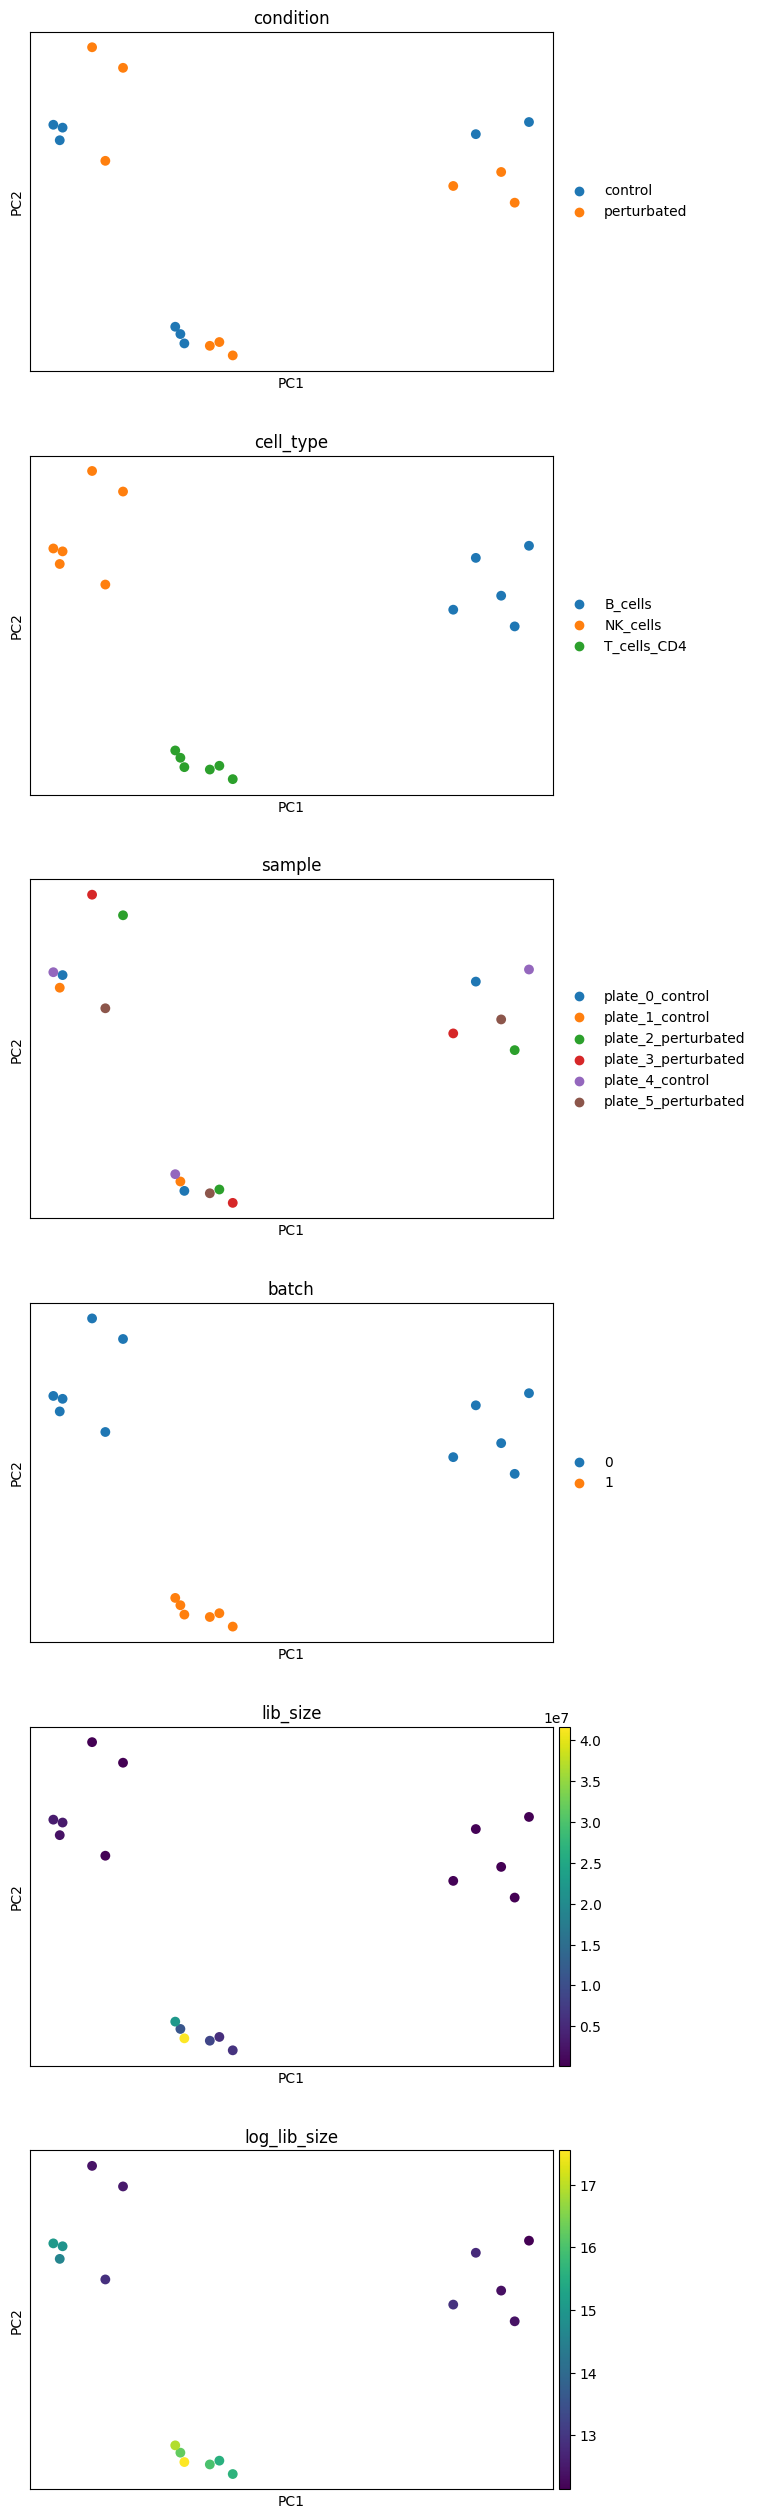

In [50]:
sc.pl.pca(cdata_pb, color=cdata_pb.obs, ncols=1, size=200)

The PCA plots show the separation of reducted gene expression across cell types as well as the separation of reducted gene expression between perturbated and control cells. Although batch and library size appear to account for the major variations in PCA components, they are captured in the variable cell type, so we do not repetitively include any of them into the design matrix.

In [51]:
cdata_pb.X = cdata_pb.layers['counts'].copy()

In [52]:
cdata_pb.X

array([[2.0, 4.0, 0.0, ..., 11.0, 3.0, 7.0],
       [0.0, 2.0, 0.0, ..., 3.0, 1.0, 2.0],
       [2.0, 6.0, 0.0, ..., 13.0, 9.0, 4.0],
       ...,
       [13.0, 24.0, 2.0, ..., 100.0, 194.0, 85.0],
       [41.0, 99.0, 177.0, ..., 383.0, 871.0, 372.0],
       [24.0, 40.0, 8.0, ..., 150.0, 308.0, 162.0]], dtype=object)

# DE analysis in cell populations of each type

In [122]:
cdata_pb_noB = cdata_pb[cdata_pb.obs['cell_type'] != 'B_cells']

In [133]:
%%R
fit_model <- function(adata_obj){
    y <- DGEList(assay(adata_obj, "X"), group = colData(adata_obj)$condition)
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    # Filtering keeps genes that have count-per-million (CPM) above k in n samples, where k is determined by min.count and by the sample library sizes, and n is determined by the design matrix.
    # n is essentially the smallest group sample size or, more generally, the minimum inverse leverage of any fitted value. 
    y <- y[keep, , keep.lib.sizes=FALSE] # The lib.size for each sample will be recalculated after filtering
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    y <- calcNormFactors(y)
    # Generate a vector by combining the condition and cell type, for the subsequent use of creating contrasts.
    group <- paste0(colData(adata_obj)$condition, ".", colData(adata_obj)$cell_type)
    if (length(colData(adata_obj)$replicate) != 0) {
        replicate <- colData(adata_obj)$replicate
        design_mat <- model.matrix(~ group + replicate) 
    } else {
    design_mat <- model.matrix(~ 0 + group) } # For making contrasts
    # design_mat <- model.matrix(~ 0 + group + replicate) 
    # The design matrix will exclude a column of ones for the intercept.
    # A model without an intercept term would only be recommended in cases where there is a strong biological reason why a zero covariate should be associated with a zero expression value, and such contexts are rare in gene expression modelling.
    y <- estimateDisp(y, design = design_mat)
    fit <- glmQLFit(y, design_mat)
    return(list("fit"=fit, "design"=design_mat, "y"=y))
}

In [134]:
# Ensure that all data types (dtypes) in the columns of a pandas DataFrame within the AnnData object are not of type "object"
for column in cdata_pb_noB.obs.columns:
    print(cdata_pb_noB.obs[column].dtype)
    if cdata_pb_noB.obs[column].dtype == 'object':
        cdata_pb_noB.obs[column] = cdata_pb_noB.obs[column].astype('category')
    if cdata_pb_noB.obs[column].dtype == 'category':
        cdata_pb_noB.obs[column] = cdata_pb_noB.obs[column].astype('str')

object
object
object
object
object
float64


In [135]:
# Ensure that all numpy.array are sparse.csc_matrix and all categorical series are strings
import numpy as np
import scipy.sparse as sp

def convert_to_sparse_float(array):
    if not sp.issparse(array):
        if array.dtype == np.dtype('O'):
            array = array.astype(float)
        array = sp.csc_matrix(array)
    return array

cdata_pb_noB.X = convert_to_sparse_float(cdata_pb_noB.X)
cdata_pb_noB.layers['counts'] = convert_to_sparse_float(cdata_pb_noB.layers['counts'])
cdata_pb_noB.obsm['X_pca'] = convert_to_sparse_float(cdata_pb_noB.obsm['X_pca'])
cdata_pb_noB.varm['PCs'] = convert_to_sparse_float(cdata_pb_noB.varm['PCs'])

In [102]:
%%R
fit_model <- function(adata_obj){
    y <- DGEList(assay(adata_obj, "X"), group = colData(adata_obj)$condition)
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    # Filtering keeps genes that have count-per-million (CPM) above k in n samples, where k is determined by min.count and by the sample library sizes, and n is determined by the design matrix.
    # n is essentially the smallest group sample size or, more generally, the minimum inverse leverage of any fitted value. 
    y <- y[keep, , keep.lib.sizes=FALSE] # The lib.size for each sample will be recalculated after filtering
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    y <- calcNormFactors(y)
    # Generate a vector by combining the condition and cell type, for the subsequent use of creating contrasts.
    group <- paste0(colData(adata_obj)$condition, ".", colData(adata_obj)$cell_type)
    if (length(colData(adata_obj)$replicate) != 0) {
        replicate <- colData(adata_obj)$replicate
        design_mat <- model.matrix(~ group + replicate) 
    } else {
    design_mat <- model.matrix(~ group) }
    # design_mat <- model.matrix(~ 0 + group + replicate) 
    # The design matrix will exclude a column of ones for the intercept.
    # A model without an intercept term would only be recommended in cases where there is a strong biological reason why a zero covariate should be associated with a zero expression value, and such contexts are rare in gene expression modelling.
    y <- estimateDisp(y, design = design_mat)
    fit <- glmQLFit(y, design_mat)
    return(list("fit"=fit, "design"=design_mat, "y"=y))
}

In [136]:
%%R -i cdata_pb_noB
fit_result <- fit_model(cdata_pb_noB)

[1] "Dimensions before subsetting:"
[1] 21231    12
[1] ""
[1] "Dimensions after subsetting:"
[1] 11130    12
[1] ""


In [137]:
%%R
(model_fit <- fit_result$fit)
(y <- fit_result$y)

An object of class "DGEList"
$counts
         donor_plate_0_control_0-1-0 donor_plate_1_control_0-1-0
A1BG-AS1                          21                           6
A2M                               59                          49
A2M-AS1                          144                         130
AAAS                              28                          26
AACS                              27                          11
         donor_plate_2_perturbated_0-1-0 donor_plate_3_perturbated_0-1-0
A1BG-AS1                               1                               1
A2M                                    0                               1
A2M-AS1                                1                               3
AAAS                                   4                               2
AACS                                   1                               2
         donor_plate_4_control_0-1-0 donor_plate_5_perturbated_0-1-0
A1BG-AS1                          16                              

In [138]:
%%R -i cdata_pb_noB
colData(cdata_pb_noB)$cell_type

    donor_plate_0_control_0-1-0     donor_plate_1_control_0-1-0 
                     "NK_cells"                      "NK_cells" 
donor_plate_2_perturbated_0-1-0 donor_plate_3_perturbated_0-1-0 
                     "NK_cells"                      "NK_cells" 
    donor_plate_4_control_0-1-0 donor_plate_5_perturbated_0-1-0 
                     "NK_cells"                      "NK_cells" 
      donor_plate_0_control_0-1       donor_plate_1_control_0-1 
                  "T_cells_CD4"                   "T_cells_CD4" 
  donor_plate_2_perturbated_0-1   donor_plate_3_perturbated_0-1 
                  "T_cells_CD4"                   "T_cells_CD4" 
      donor_plate_4_control_0-1   donor_plate_5_perturbated_0-1 
                  "T_cells_CD4"                   "T_cells_CD4" 


In [140]:
%%R -i cdata_pb_noB -o de_cell_type
de_cell_type <- list()
for (cell_type in unique(colData(cdata_pb_noB)$cell_type)) {
    print(cell_type)
    contrast_cell_type <- makeContrasts(paste0("groupperturbated.", cell_type, "-groupcontrol.", cell_type), levels=y$design)
    qlf <- glmQLFTest(model_fit, contrast=contrast_cell_type)
    tt <- topTags(qlf, n=Inf)
    de_cell_type[[cell_type]] <- tt$table
}

[1] "NK_cells"
[1] "T_cells_CD4"


In [84]:
cdata_cd4 = cdata_pb[cdata_pb.obs['cell_type'] == 'T_cells_CD4']

In [141]:
de_cell_type

o{'NK_cells':               logFC    logCPM             F        PValue       FDR
IFIT3     -4.415284  6.346226  1.697737e+02  6.216328e-10  0.000003
MX1       -4.524721  6.883945  1.685377e+02  6.559042e-10  0.000003
ISG15     -3.173386  8.575934  1.628939e+02  8.419660e-10  0.000003
IFI6      -2.740889  7.752869  1.467822e+02  1.798708e-09  0.000005
XAF1      -2.117242  6.944051  1.322962e+02  3.808123e-09  0.000008
...             ...       ...           ...           ...       ...
ZNF268     0.004206  3.154574  9.863964e-05  9.998679e-01  1.000000
OTUD7B    -0.000029  2.860976  1.506821e-08  9.999036e-01  1.000000
CERS4     -0.000024  2.930438  4.835148e-09  9.999454e-01  1.000000
F5         0.000000  2.881848  0.000000e+00  1.000000e+00  1.000000
KRT73-AS1  0.000000  2.534248  0.000000e+00  1.000000e+00  1.000000

[11130 rows x 5 columns], 'T_cells_CD4':            logFC    logCPM             F        PValue           FDR
IFIT3  -3.113962  6.346226  3.003681e+02  8.653453e-12  6.9

In [142]:
cell_types = de_cell_type.keys()
# Save the DE result table to cdata.uns for each cell type, and export the DE result table to CSV files
for cell_type in cell_types:
    df = de_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata=cdata,
        de_res=df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_{cell_type}.csv")
# Reference: https://sc-toolbox.readthedocs.io/en/latest/usage/tools/sc_toolbox.tools.de_res_to_anndata.html

In [181]:
cdata

AnnData object with n_obs × n_vars = 19281 × 21231
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control', 'sm_cluster_3', 'sm_cluster_5', 'sm_cluster_7', 'sm_cluster_9', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'condition', 'sample'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'edgeR_NK_cells', 'edgeR_T_cells_CD4'
    layers: 'counts'

In [148]:
cdata.uns['edgeR_NK_cells']

{'params': {'groupby': 'cell_type',
  'reference': 'rest',
  'method': 'other',
  'use_raw': True,
  'layer': None,
  'corr_method': 'other'},
 'names': rec.array([('MALAT1',), ('MT-RNR2',), ('B2M',), ..., ('RAB38',),
            ('TRGV8',), ('L3MBTL4',)],
           dtype=[('NK_cells', 'O')]),
 'scores': rec.array([(16.0111335641762,), (14.103958781362099,),
            (13.837508104683382,), ..., (-0.04087479791840362,),
            (-0.126530968651615,), (-0.1541152324928,)],
           dtype=[('NK_cells', 'O')]),
 'pvals': rec.array([(0.7575965567436469,), (0.025272670603362864,),
            (0.034201837924696714,), ..., (0.6589786013049067,),
            (0.1600918815632324,), (0.8212764756211435,)],
           dtype=[('NK_cells', 'O')]),
 'pvals_adj': rec.array([(0.8927425632320027,), (0.13863224436443009,),
            (0.16666278271401294,), ..., (0.8386331936589477,),
            (0.3996658447459344,), (0.9227546107069783,)],
           dtype=[('NK_cells', 'O')]),
 'logfoldch

In [177]:
nk_data = cdata.uns['edgeR_NK_cells']
dict_to_df_nk = {
    "Gene symbols": nk_data['names']['NK_cells'], 
    "log CPM": nk_data['scores']['NK_cells'],
    "P value": nk_data['pvals']['NK_cells'],
    "FDR": nk_data['pvals_adj']['NK_cells'],
    "Log fold change": nk_data['logfoldchanges']['NK_cells']
}

In [178]:
dict_to_df_nk

{'Gene symbols': array(['MALAT1', 'MT-RNR2', 'B2M', ..., 'RAB38', 'TRGV8', 'L3MBTL4'],
       dtype=object),
 'log CPM': array([16.0111335641762, 14.103958781362099, 13.837508104683382, ...,
        -0.04087479791840362, -0.126530968651615, -0.1541152324928],
       dtype=object),
 'P value': array([0.7575965567436469, 0.025272670603362864, 0.034201837924696714,
        ..., 0.6589786013049067, 0.1600918815632324, 0.8212764756211435],
       dtype=object),
 'FDR': array([0.8927425632320027, 0.13863224436443009, 0.16666278271401294, ...,
        0.8386331936589477, 0.3996658447459344, 0.9227546107069783],
       dtype=object),
 'Log fold change': array([-0.051995933603402454, -0.44504806450169215, -0.3065557039810241,
        ..., 0.35367422519964237, 1.0191493017233186, 0.1889670223588023],
       dtype=object)}

In [179]:
pd.DataFrame(dict_to_df_nk)

,Gene symbols,log CPM,P value,FDR,Log fold change
0,MALAT1,16.011134,0.757597,0.892743,-0.051996
1,MT-RNR2,14.103959,0.025273,0.138632,-0.445048
2,B2M,13.837508,0.034202,0.166663,-0.306556
3,RPLP1,13.516694,0.007238,0.065867,0.526471
4,TPT1,13.49751,0.085977,0.286849,0.288236
...,...,...,...,...,...
11125,CERCAM,0.415279,0.009675,0.079306,1.654401
11126,IGF2BP2,0.312608,0.059956,0.233243,1.477706
11127,RAB38,-0.040875,0.658979,0.838633,0.353674
11128,TRGV8,-0.126531,0.160092,0.399666,1.019149


In [85]:
cdata_cd4.obs_names

Index(['donor_plate_0_control_0-1', 'donor_plate_1_control_0-1',
       'donor_plate_2_perturbated_0-1', 'donor_plate_3_perturbated_0-1',
       'donor_plate_4_control_0-1', 'donor_plate_5_perturbated_0-1'],
      dtype='object')

In [86]:
cdata_pb.obs_names = [
    i.split("_")[2] + "_" + i.split("_")[3] for i in cdata_pb.obs_names
]

In [87]:
cdata_pb.obs_names

Index(['0_control', '1_control', '2_perturbated', '3_perturbated', '4_control',
       '5_perturbated'],
      dtype='object')

In [88]:
cdata_pb.obs

,condition,cell_type,sample,batch,lib_size,log_lib_size
0_control,control,T_cells_CD4,plate_0_control,1,41624636.0,17.544203
1_control,control,T_cells_CD4,plate_1_control,1,11336428.0,16.243532
2_perturbated,perturbated,T_cells_CD4,plate_2_perturbated,1,5791472.0,15.571897
3_perturbated,perturbated,T_cells_CD4,plate_3_perturbated,1,6216921.0,15.642785
4_control,control,T_cells_CD4,plate_4_control,1,22339083.0,16.921848
5_perturbated,perturbated,T_cells_CD4,plate_5_perturbated,1,8803763.0,15.990690


## Two issues when using an anndata object in %%R

1. ValueError: Converting pandas 'Category' series to R factor is only possible when categories are strings
2. [NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'](https://github.com/theislab/anndata2ri/issues/50)

In [89]:
# Ensure that all data types (dtypes) in the columns of a pandas DataFrame within the AnnData object are not of type "object"
for column in cdata_pb.obs.columns:
    print(cdata_pb.obs[column].dtype)
    if cdata_pb.obs[column].dtype == 'object':
        cdata_cd4.obs[column] = cdata_cd4.obs[column].astype('category')
    if cdata_cd4.obs[column].dtype == 'category':
        cdata_cd4.obs[column] = cdata_cd4.obs[column].astype('str')

category
category
category
category
object
float64


In [90]:
cdata_cd4

AnnData object with n_obs × n_vars = 6 × 21231
    obs: 'condition', 'cell_type', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'condition_colors', 'cell_type_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [91]:
# Ensure that all numpy.array are sparse.csc_matrix and all categorical series are strings
import numpy as np
import scipy.sparse as sp

def convert_to_sparse_float(array):
    if not sp.issparse(array):
        if array.dtype == np.dtype('O'):
            array = array.astype(float)
        array = sp.csc_matrix(array)
    return array

cdata_cd4.X = convert_to_sparse_float(cdata_cd4.X)
cdata_cd4.layers['counts'] = convert_to_sparse_float(cdata_cd4.layers['counts'])
cdata_cd4.obsm['X_pca'] = convert_to_sparse_float(cdata_cd4.obsm['X_pca'])
cdata_cd4.varm['PCs'] = convert_to_sparse_float(cdata_cd4.varm['PCs'])

In [92]:
cdata_cd4.X

<6x21231 sparse matrix of type '<class 'numpy.float64'>'
	with 109464 stored elements in Compressed Sparse Column format>

In [103]:
%%R -i cdata_cd4
fit_result <- fit_model(adata_obj = cdata_cd4)

[1] "Dimensions before subsetting:"
[1] 21231     6
[1] ""
[1] "Dimensions after subsetting:"
[1] 12819     6
[1] ""


In [104]:
%%R
(model_fit <- fit_result$fit)

An object of class "DGEGLM"
$coefficients
         (Intercept) groupperturbated.T_cells_CD4
A1BG       -13.05474                   0.19826520
A1BG-AS1   -12.36697                   0.23025545
A2M        -12.23982                  -1.74638233
A2M-AS1    -11.57138                  -1.20628927
AAAS       -11.65340                   0.07192908
12814 more rows ...

$fitted.values
         0_control 1_control 2_perturbated 3_perturbated 4_control
A1BG      95.03083  24.05589     14.851850     15.158310  47.91356
A1BG-AS1 189.37843  47.93884     30.549978     31.180361  95.48265
A2M      215.09665  54.44909      4.769608      4.868026 108.44951
A2M-AS1  420.02471 106.32413     16.073412     16.405079 211.77213
AAAS     386.92355  97.94497     53.262115     54.361152 195.08286
         5_perturbated
A1BG          22.77496
A1BG-AS1      46.84766
A2M            7.31408
A2M-AS1       24.64820
AAAS          81.67619
12814 more rows ...

$deviance
     A1BG  A1BG-AS1       A2M   A2M-AS1      AAAS 


In [105]:
%%R
(y <- fit_result$y)

An object of class "DGEList"
$counts
         0_control 1_control 2_perturbated 3_perturbated 4_control
A1BG            99        27            16            13        41
A1BG-AS1       183        48            43            24        99
A2M             89        55             7             2       177
A2M-AS1        261       112            18             9       288
AAAS           368       123            47            62       163
         5_perturbated
A1BG                24
A1BG-AS1            40
A2M                  8
A2M-AS1             31
AAAS                80
12814 more rows ...

$samples
                    group lib.size norm.factors
0_control         control 41473627    1.0745918
1_control         control 11309106    0.9975719
2_perturbated perturbated  5775575    0.9884277
3_perturbated perturbated  6204297    0.9391129
4_control         control 22283949    1.0083640
5_perturbated perturbated  8783851    0.9966260

$design
  (Intercept) groupperturbated.T_cells_CD4
1    

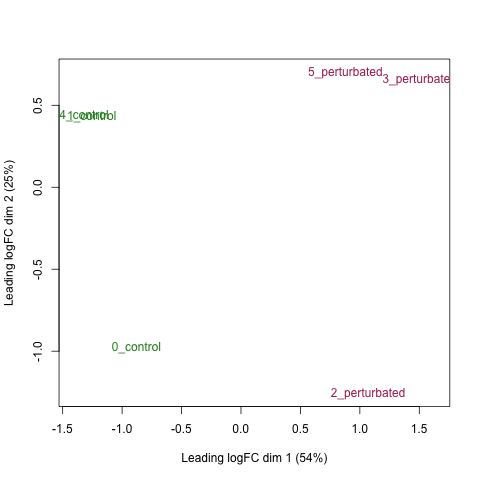

In [106]:
%%R
plotMDS(y, col=ifelse(y$samples$group == 'perturbated', 'maroon', 'forestgreen'))

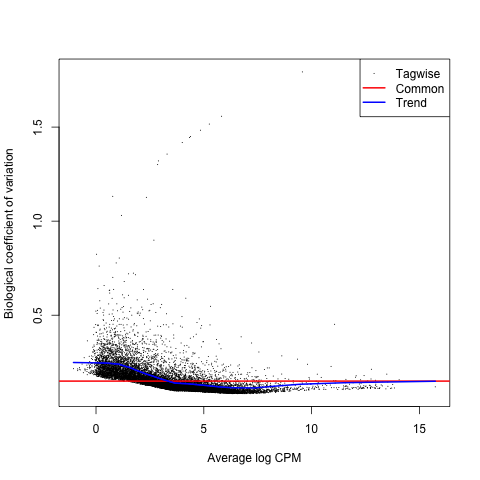

In [107]:
%%R
plotBCV(y)

In [108]:
%%R
colnames(y$design)

[1] "(Intercept)"                  "groupperturbated.T_cells_CD4"


## Estimate all DE genes

In [109]:
%%R
y$design

  (Intercept) groupperturbated.T_cells_CD4
1           1                            0
2           1                            0
3           1                            1
4           1                            1
5           1                            0
6           1                            1
attr(,"assign")
[1] 0 1
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"



## Design matrix: ~ group

In [110]:
%%R -o tt
contrast <- makeContrasts('groupperturbated.T_cells_CD4', levels=y$design)
qlf <- glmQLFTest(model_fit, contrast=contrast)
tt <- topTags(qlf, n=Inf)
tt <- tt$table

In addition: Warning message:
In makeContrasts("groupperturbated.T_cells_CD4", levels = y$design) :
  Renaming (Intercept) to Intercept


In [111]:
tt

,logFC,logCPM,F,PValue,FDR
IFIT3,-3.092989,5.680483,4.218179e+02,3.078748e-09,0.000015
IFI44L,-3.263613,6.556056,4.155431e+02,3.302870e-09,0.000015
BEX5,2.092208,5.161734,4.122098e+02,3.429941e-09,0.000015
DNAJB1,-1.757186,6.495728,3.647760e+02,6.078582e-09,0.000016
ADI1,-3.057785,4.985321,3.611911e+02,6.365750e-09,0.000016
...,...,...,...,...,...
LINC02210,-0.000199,3.642759,6.980715e-07,9.993505e-01,0.999662
NUP98,-0.000063,4.509983,3.018454e-07,9.995729e-01,0.999763
TMEM199,-0.016617,3.808436,2.140934e-02,9.996069e-01,0.999763
CCSER2,0.000037,6.192699,6.597543e-08,9.998003e-01,0.999823


## Design matrix: ~ 0 + group

[When to include or not the intercept in the design matrix](https://support.bioconductor.org/p/128516/)

In [100]:
%%R -o tt
contrast <- makeContrasts('groupperturbated.T_cells_CD4-groupcontrol.T_cells_CD4', levels=y$design)
qlf <- glmQLFTest(model_fit, contrast=contrast)
tt <- topTags(qlf, n=Inf)
tt <- tt$table

In [101]:
tt

,logFC,logCPM,F,PValue,FDR
IFIT3,-3.092989,5.680483,4.218179e+02,3.078748e-09,0.000015
IFI44L,-3.263613,6.556056,4.155431e+02,3.302870e-09,0.000015
BEX5,2.092208,5.161734,4.122098e+02,3.429941e-09,0.000015
DNAJB1,-1.757186,6.495728,3.647760e+02,6.078582e-09,0.000016
ADI1,-3.057785,4.985321,3.611911e+02,6.365750e-09,0.000016
...,...,...,...,...,...
LINC02210,-0.000199,3.642759,6.980910e-07,9.993505e-01,0.999662
NUP98,-0.000063,4.509983,3.018474e-07,9.995729e-01,0.999763
TMEM199,-0.016617,3.808436,2.140934e-02,9.996069e-01,0.999763
CCSER2,0.000037,6.192699,6.597526e-08,9.998003e-01,0.999823


## Genewise statistical tests for a given coefficient or contrast relative to a specified fold-change threshold

In [112]:
%%R
qlt <- glmTreat(model_fit, contrast=contrast, lfc=1.5)
topTags(qlt)

Coefficient:  1*groupperturbated.T_cells_CD4 
            logFC unshrunk.logFC   logCPM       PValue          FDR
IFI44L  -3.263613      -3.264177 6.556056 9.533981e-08 0.0007429515
IFIT3   -3.092989      -3.093920 5.680483 1.159141e-07 0.0007429515
ADI1    -3.057785      -3.059266 4.985321 2.571450e-07 0.0010987807
METRN    2.749798       2.750406 5.847060 7.349532e-07 0.0023553413
CTNNAL1  3.112246       3.115402 3.747237 1.423659e-06 0.0034630877
NRGN     4.502046       4.528753 1.886567 1.620916e-06 0.0034630877
RSAD2   -2.822134      -2.823467 4.899794 2.281681e-06 0.0035348597
TRIP10   3.061221       3.068475 2.394709 2.372549e-06 0.0035348597
HERC6   -3.291868      -3.296417 3.686144 2.820902e-06 0.0035348597
AVEN    -3.496108      -3.512929 2.196805 3.055553e-06 0.0035348597


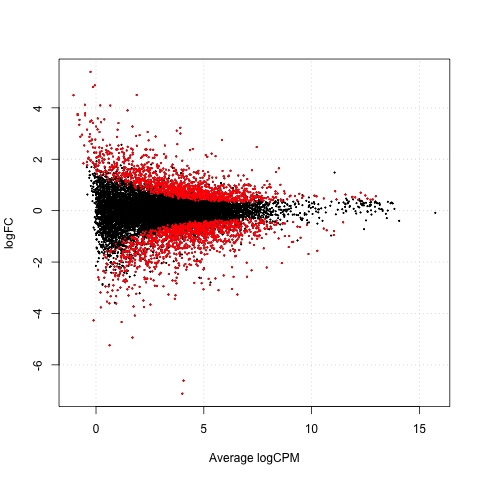

In [113]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])